# Homework 4. Moleculal dynamics simulation  of 2D soft-disk fluid

In this homework, you will use molecular dynamics to simulate the behavior of fluid consisting of soft disks in two dimensions. The particles in this fluid interact with each other via the pairwise potential of the following form: 

 $$  u(r_{ij})=\left\{
                \begin{array}{ll}
                  4\epsilon \left[ 
                  \left (
                  \frac{\sigma}{r_{ij} }
                  \right )^{12} 
                  -
                   \left (
                  \frac{\sigma}{r_{ij} }
                  \right )^{6} + 
                  \right ] + \epsilon,  \ r_{ij} < r_c\\
                  0, r_{ij} \geq r_c, r_c = 2^{1/6}\sigma
                \end{array}
              \right.
$$

For this model, we will use reduced MD units, such that $\sigma = 1 $, $  \epsilon=1$,  $k_b = 1$.
All the particles have unit mass.

$ r_c = 2^{1/6}\sigma $

**The homework consists of 5 tasks, 25 points total. You should work in groups of 3-4 people and submit one solution for each group within 3 weeks. You can use GitHub for collaboration.**

## Task 1.  System initialization

1) Write a function that assigns coordinates of  N particles on a square grid inside a square box with side length L. This function should return a 2d array with coordinates for each particle. (1 pt)

2) Write a function that takes temperature as input and initializes particle velocities consistent with the given temperature. Make sure that the total momentum of the system is zero. (2 pt)


In [6]:
import numpy as np
import matplotlib.pyplot as plt

from utils import plot, plot_forces_on_particles
from build_ensemble import square_build
from evolve import force, v_radial_pbc, calculate_energies, move, equilibriate
from data_types import Configuration

/Users/admin/Documents/Projects/langevin/src/soft-disks/utils.py:47: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


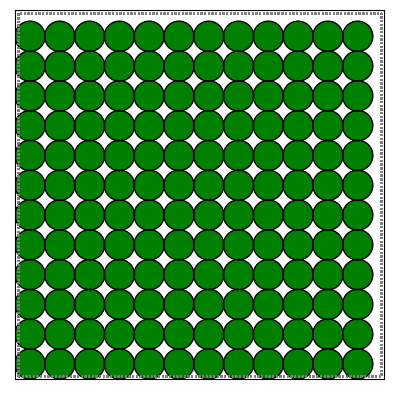

In [7]:
#configuration parameters are defined in config.py
configuration = square_build(n=144, l=12)
configuration.forces = force(configuration.positions, configuration.metadata)
#configuration.positions
plot(configuration)

In [8]:
# Velocity initialization
np.mean(configuration.velocities, axis=0)

array([-7.70988212e-19,  3.85494106e-17])

## Task 2. Building MD code  


1) Write code to perform molecular dynamics simulation of your system according to the following algorithm:

 *  Initialize positions, velocities, and accelerations for your system.
 * For each modeling step:
      - Update coordinates using velocity Verlet algorithm. (1 pt)
      - Apply periodic boundary conditions to coordinates. (1pt)
      - Calculate the force acting on each particle and accelerations. Keep in mind minimum image convention! (4 pt)
      - Update velocities using velocity Verlet algorithm. (1pt)

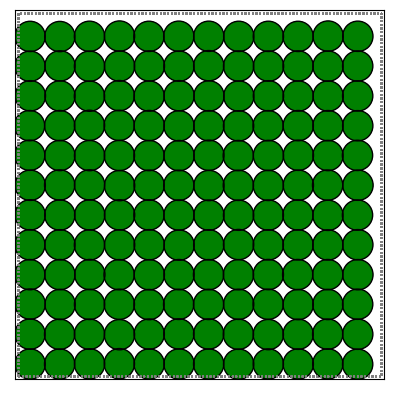

In [9]:
# Verlet integrator
plot(move(configuration))

## Task 3. Simulations in the microcanonical ensemble

1) Use the code you wrote in task 3 to run MD simulation of a system with 36 particles in a square box with side length L = 6 for at least 5000 steps. Initialize velocities using T=1. Use integration step dt = 0.005. Save coordinates and velocities at each step to a file. (2 pt)

2) For each timestep, calculate and plot the following values as a function of time: $\sum_i^{N particles} V_x^i $, $\sum_y^{N particles} V_y^i $, $E_{total}$, $E_{potential}$, $E_{kinetic}$, temperature. Which of the these values should be conserved? Do your results match the prediction?  (3 pt)

3) Was the modeling time enough for the system to equilibrate? Explain.  (1 pt)


In [ ]:
# Please run this again, the code was move and ran out of time to run again. For results see the other 
np.random.seed(489)
starting_conf = square_build(36, 6)
newconf, energies, velocities = equilibriate(starting_conf, nsteps=5000, cache_interval=10, folder_name='part_3')

In [ ]:
plt.plot(velocities[:,0], label=r'$\overline{|v_x|}$')
plt.plot(velocities[:,1], label=r'$\overline{|v_y|}$')

plt.ylabel("Velocity (reduced units)")
plt.xlabel("Time (reduced units)")

plt.title("Average Velocity Components")
plt.legend()

In [ ]:
plt.title('Energies Against Reduced Simulation Time')
plt.plot(energies[1], label="Potential Energy")
plt.plot(energies[0], label="Kinetic Energy")
plt.plot(energies[0]+energies[1], label="Total Energy")


time_ticks = np.arange(0,energies[0].size, 100 if energies[0].size/100 <= 10 else 1000)
plt.xticks(time_ticks, time_ticks*10)
plt.xlabel("Reduced Time")
plt.ylabel("Reduced Energy")

plt.legend()

In [ ]:
plot_forces_on_particles(newconf, particle_labels=False)
calculate_energies(newconf)

## Task 4. Constant temperature molecular  dynamics

In this task, you will extend code from task 2 to run the simulation at a constant temperature using Langevin dynamics.

1) Implement integration of the Langevin equation. (2 pt)

2) Simulate cooling of the liquid with 144 particles in the box with L=12. First, run the simulation at T=1.4 for 2000 steps. Use final coordinates and velocities to start another simulation, this time with T=1.2.  Run this lower-temperature simulation for 2000 steps. Keep restarting the simulation, each time decreasing the temperature by 0.2. The final run should be performed at T=0.6  In all the simulations, use a constant friction coefficient of your choice. (2 pt)

3) Visualize several frames from a low-temperature fragment of the trajectory. These frames represent the microscopic structure of the frozen soft-disk liquid. Is the structure different from the initial square-grid arrangement? (1 pt)

In [74]:
def Langevin_integrator(configuration: Configuration, N, gamma, m, dt, T):
    
    alpha = np.exp(-gamma*dt)
    R = np.random.normal(0, 1, size=(N,2)) #R_variance = np.sqrt(2*gamma*m*k*T) 

    accelerations = configuration.forces/m

    velocities_Langevin = configuration.velocities*alpha + accelerations*(1-alpha)/gamma + np.sqrt(T*(1-alpha**2)/m)*R #k = 1
    positions = configuration.positions + velocities_Langevin*dt

    positions -= 6
    positions_Langevin = v_radial_pbc(positions) #check boundary conditions
    positions_Langevin += 6

    forces_Langevin = force(positions_Langevin)
    #acceleration_Langevin = forces_Langevin/m

    configuration_Langevin = Configuration(
                    positions_Langevin,
                    velocities_Langevin,
                    forces_Langevin
                    )
    
    return configuration_Langevin


In [63]:
def Langevin_simulation(configuration: Configuration, N, gamma, m, dt, T, steps):

    current_configuration = configuration
    
    energy = []
    frames_pos = []

    for i in range(steps):
        
        _new_conf = Langevin_integrator(current_configuration, N, gamma, m, dt, T)
        energy.append(calculate_energies(_new_conf))
        current_configuration = _new_conf
        if i%250 == 0:
            frames_pos.append(_new_conf.positions)
    return current_configuration, energy, frames_pos

In [81]:
# Cooling

N = 144
L = 12
T = [1.4, 1.2, 1.0, 0.8, 0.6]
steps = 2000
gamma = 2
dt = 0.005
m = 1

# velocity_variance = T
# lj_cutoff = sigma*2**(1/6)

configuration = square_build()

forces = force(configuration.positions)

current_configuration = Configuration(
        configuration.positions,
        configuration.velocities,
        forces
)


In [130]:
configs = []
energies = []
frames_T_pos = []

for t in T:

    _config, E, frame = Langevin_simulation(current_configuration, N, gamma, m, dt, t, steps)
    configs.append(_config)
    energies.append(E)
    frames_T_pos.append(frame)
    current_configuration = _config


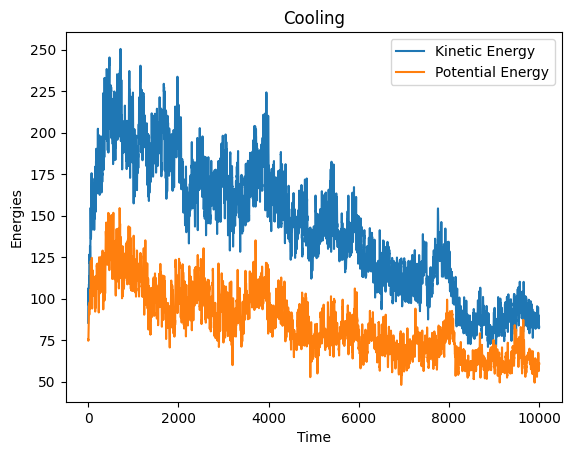

In [131]:
energies = np.array(energies)

kinetic_energy = []
potential_energy = []

for i in range(5):
    kinetic_energy.append(energies[i][:,0])
    potential_energy.append(energies[i][:,1])

kinetic_energy_tot = np.concatenate(kinetic_energy)
potential_energy_tot = np.concatenate(potential_energy)

plt.plot(kinetic_energy_tot, label= 'Kinetic Energy')
plt.plot(potential_energy_tot, label= 'Potential Energy')
plt.title('Cooling')
plt.xlabel('Time')
plt.ylabel('Energies')
plt.legend()



/Users/macbook/Documents/langevin/src/soft-disks/utils.py:49: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


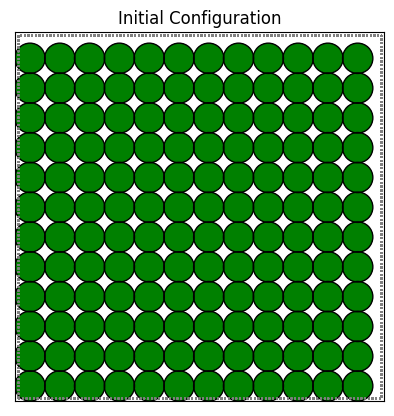

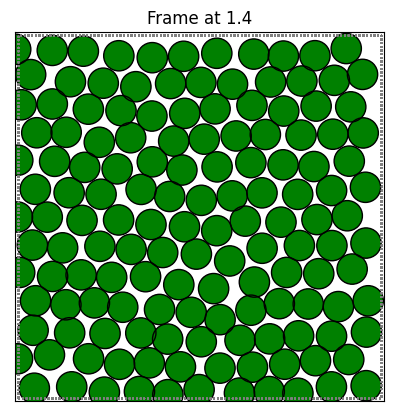

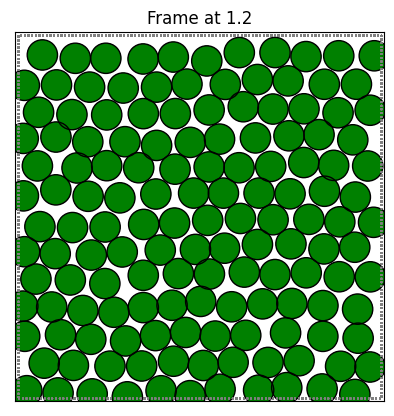

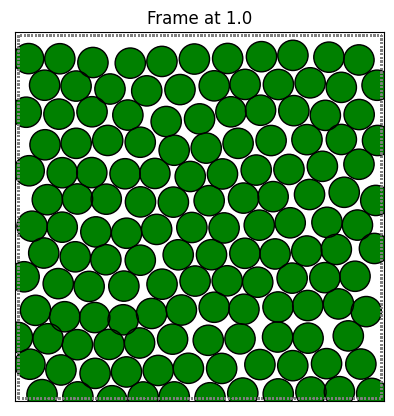

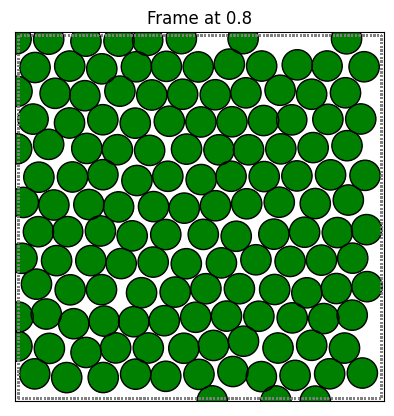

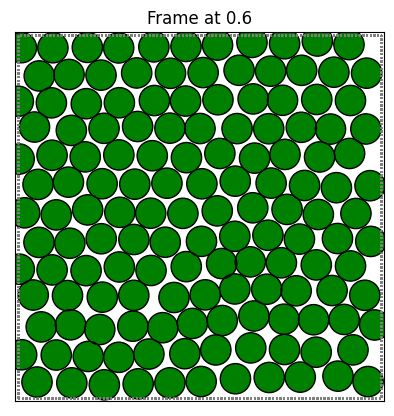

In [139]:
# Frames

plot(configuration)
plt.title('Initial Configuration')

for i in range(5):
    plot(configs[i])
    plt.title(f"Frame at {T[i]}")

As temperature lowers, the configuration obtained from the simulation tends to show a hexagonal arrangement of the particles.

## Task 5. Considerations when modeling realistic systems

It is easy to run a simulation that yields meaningless results when doing molecular dynamics simulation. To avoid this problem, one should know the properties and limitations of the algorithms used. To prevent some of the common pitfalls in the future, answer the following questions.

1) What is the maximum cut-off radius for nonbonded interactions in a periodic system with cubic box size L?  Explain your answer. (1 pt)

2) Can the Andersen thermostat be used to study dynamic properties of the system, such as diffusion coefficients. Why? (1 pt)

3) What is the purpose of the particle mesh Evald (PME) algorithm? Please briefly describe the method and a) why it is used, b) which caveats does it have, c) what are the alternatives (3 pt)

---------

1. The cut-off radius should be smaller than L/2 in order to avoid considering interactions between a particle and its own image.

2. The Andersen thermostat can be used only for simulation at constant temperature. Also, given its stochastic nature (i.e. assigns the velocities values randomly from the Maxwell-Boltzmann distribuition) is not suitable for the determination of dynamic properties such as the diffusion coeffiecient.

3. Ewald summation is a method for computing long-range interactions (e.g. electrostatic interactions) in periodic systems.

    The generic interaction potential is separated into two terms $u(\vec{r}) = u_{sr}(\vec{r})+ u_{lr}(\vec{r})$; the idea of PME is to replace the direct summation of interaction energies between particles as the sum of two terms $E_{tot} = E_{sr}+ E_{lr}$.
    $E_{sr}$ is given by the short-ranged potential in real space and $E_{lr}$ is given by the Fourier transform of the long-ranged part.

    PME is mainly used for systems with periodic symmetry, i.e. molecular dynamics.

    It requires periodic boundary conditions for which a cut-off radius must be used for the reasons explained in answer (1).